In [2]:
from utils import *

import torch
from torch import nn
from torch.nn import functional as F

from torchsummary import summary

In [3]:
!pip install torchsummary torchvision utils

In [4]:
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu125



In [5]:
print(torch.cuda.is_available())

True


In [6]:
#Get the GPU name
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3050 Ti Laptop GPU'

# Analyse and visualise the dataset

In [8]:
# `ToTensor` converts the image data from PIL type to 32-bit floating point
# tensors. It divides all numbers by 255 so that all pixel values are between
# 0 and 1
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../data", train=False, transform=trans, download=True)

In [9]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [10]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

In [11]:
def get_fashion_mnist_labels(labels):  #@save
    """Return text labels for the Fashion-MNIST dataset."""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [12]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # Tensor Image
            ax.imshow(img.numpy())
        else:
            # PIL Image
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

torch.Size([18, 1, 28, 28]) torch.float32 torch.Size([18]) torch.int64


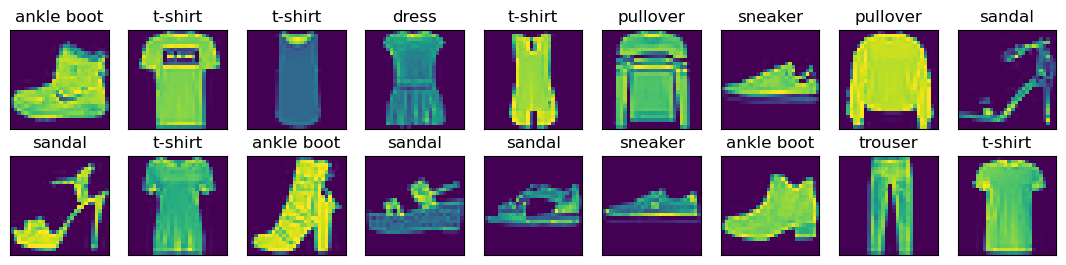

In [13]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y));
print(X.shape, X.dtype, y.shape, y.dtype)

In [14]:
def get_dataloader_workers():
    return 4  # Use 4 processes to read the data.

batch_size = 128
train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,
                             num_workers=get_dataloader_workers())
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

torch.Size([128, 1, 28, 28]) torch.float32 torch.Size([128]) torch.int64


# Putting All Things Together

In [16]:
def get_dataloader_workers():
    return 4  # Use 4 processes to read the data.

def load_data_fashion_mnist(batch_size, resize=None):  
    """Download the Fashion-MNIST dataset and then load it into memory."""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

In [17]:
train_iter, test_iter = load_data_fashion_mnist(128, resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

torch.Size([128, 1, 64, 64]) torch.float32 torch.Size([128]) torch.int64


In [18]:
def train(net, train_iter, test_iter, num_epochs, lr,
              device=try_gpu()):
    
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            torch.nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer = Timer()
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = Accumulator(3)
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            net.train()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_loss = metric[0]/metric[2]
            train_acc = metric[1]/metric[2]
            if (i + 1) % 50 == 0:
                animator.add(epoch + i / len(train_iter),
                             (train_loss, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch+1, (None, None, test_acc))
    print(f'loss {train_loss:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

# CNN model and training

### LeNet

loss 0.391, train acc 0.854, test acc 0.840
28673.2 examples/sec on cuda:0


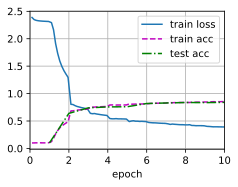

In [21]:
#LeNet
class Reshape(torch.nn.Module):
    def forward(self, x):
        return x.view(-1,1,28,28)

lenet = torch.nn.Sequential(
    Reshape(),
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))

lr, num_epochs, batch_size = 0.9, 10, 128
#lr, num_epochs, batch_size = 0.01, 10, 128
train_iter, test_iter = load_data_fashion_mnist(batch_size=batch_size)
train(lenet, train_iter, test_iter, num_epochs, lr)

In [22]:
#del alexnet

In [23]:
torch.cuda.empty_cache()

In [24]:
#gc.collect()

## AlexNet

loss 0.271, train acc 0.900, test acc 0.897
724.0 examples/sec on cuda:0


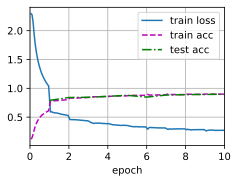

In [148]:
#AlexNet
alexnet = nn.Sequential(
    # Here, we use a larger 11 x 11 window to capture objects. At the same
    # time, we use a stride of 4 to greatly reduce the height and width of the
    # output. Here, the number of output channels is much larger than that in
    # LeNet
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # Make the convolution window smaller, set padding to 2 for consistent
    # height and width across the input and output, and increase the number of
    # output channels
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # Use three successive convolutional layers and a smaller convolution
    # window. Except for the final convolutional layer, the number of output
    # channels is further increased. Pooling layers are not used to reduce the
    # height and width of input after the first two convolutional layers
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    # Here, the number of outputs of the fully-connected layer is several
    # times larger than that in LeNet. Use the dropout layer to mitigate
    # overfitting
    nn.Linear(6400, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    # Output layer. Since we are using Fashion-MNIST, the number of classes is
    # 10, instead of 1000 as in the paper
    nn.Linear(4096, 10))

lr, num_epochs, batch_size = 0.01, 10, 64
train_iter, test_iter = load_data_fashion_mnist(batch_size, resize=224)
train(alexnet, train_iter, test_iter, num_epochs, lr)

In [149]:
VGG_RF = ReceptiveFieldCalculator()
VGG_RF.calculate(alexnet, 224)

Input: output shape = 224; receptive field = 1
Conv: output shape = 54; receptive field = 11
Pool: output shape = 26; receptive field = 19
Conv: output shape = 26; receptive field = 51
Pool: output shape = 12; receptive field = 67
Conv: output shape = 12; receptive field = 99
Conv: output shape = 12; receptive field = 131
Conv: output shape = 12; receptive field = 163
Pool: output shape = 5; receptive field = 195


In [152]:
class SimplifiedAlexNet(nn.Module):
    def __init__(self):
        super(SimplifiedAlexNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 128, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256*5*5, 1024), nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512), nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

simplified_alexnet = SimplifiedAlexNet()


loss 0.369, train acc 0.865, test acc 0.875
2677.8 examples/sec on cuda:0


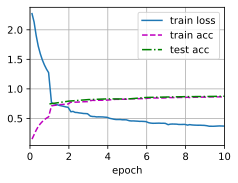

In [158]:
lr, num_epochs, batch_size = 0.01, 10, 128
train_iter, test_iter = load_data_fashion_mnist(batch_size, resize=224)
train(simplified_alexnet, train_iter, test_iter, num_epochs, lr)

loss 0.392, train acc 0.858, test acc 0.862
9057.9 examples/sec on cuda:0


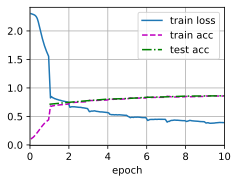

In [164]:
alexnet28 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(256 * 3 * 3, 1024), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(1024, 512), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(512, 10)
)

# Train the modified AlexNet
lr, num_epochs, batch_size = 0.01, 10, 64
train_iter, test_iter = load_data_fashion_mnist(batch_size, resize=28)
train(alexnet28, train_iter, test_iter, num_epochs, lr)

In [128]:
#VGG-11
def vgg_block(num_convs, in_channels, out_channels):
    layers=[]
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels,
                                kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

def vgg(conv_arch):
    # The convolutional part
    conv_blks=[]
    in_channels=1
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels

    return nn.Sequential(
        *conv_blks, nn.Flatten(),
        # The fully-connected part
        nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 10))

conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))
vggnet = vgg(conv_arch)

#Since VGG-11 is more computationally-heavy than AlexNet we construct a 
#network with a smaller number of channels. This is more than sufficient 
#for training on Fashion-MNIST.
#ratio = 4
#small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
#vggnet = vgg(small_conv_arch)


In [130]:
class ReceptiveFieldCalculator():
    
    def calculate(self, architecture, input_image_size):
        input_layer = (input_image_size, 1, 1)
        self._print_layer_info("Input", input_layer)
        
        for key in architecture.modules():
            
            if isinstance(key, nn.Conv2d):
                conv_operation = (key.kernel_size[0], key.stride[0], key.padding[0])
                current_layer = self._calculate_layer_info(input_layer, conv_operation)
                self._print_layer_info("Conv", current_layer)
                input_layer = current_layer

            elif isinstance(key, nn.MaxPool2d):
                conv_operation = (key.kernel_size, key.stride, key.padding)
                current_layer = self._calculate_layer_info(input_layer, conv_operation)
                self._print_layer_info("Pool", current_layer)
                input_layer = current_layer

            
    def _print_layer_info(self, layer_name, layer_info):
        print(f'{layer_name}: output shape = {layer_info[0]}; receptive field = {layer_info[1]}')     
            
    def _calculate_layer_info(self, input_layer, conv_operation):
        n_in = input_layer[0]
        r_in = input_layer[1]
        s_in = input_layer[2]

        F = conv_operation[0]
        S = conv_operation[1]
        P = conv_operation[2]
            
        n_out = math.floor((n_in - F + 2*P)/S) + 1
        s_out = s_in * S
        r_out = r_in + (F - 1)*s_in
        
        return n_out, r_out, s_out

In [132]:
torch.cuda.empty_cache()

In [134]:
VGG_RF = ReceptiveFieldCalculator()
VGG_RF.calculate(vggnet, 224)

Input: output shape = 224; receptive field = 1
Conv: output shape = 224; receptive field = 3
Pool: output shape = 112; receptive field = 4
Conv: output shape = 112; receptive field = 8
Pool: output shape = 56; receptive field = 10
Conv: output shape = 56; receptive field = 18
Conv: output shape = 56; receptive field = 26
Pool: output shape = 28; receptive field = 30
Conv: output shape = 28; receptive field = 46
Conv: output shape = 28; receptive field = 62
Pool: output shape = 14; receptive field = 70
Conv: output shape = 14; receptive field = 102
Conv: output shape = 14; receptive field = 134
Pool: output shape = 7; receptive field = 150


In [136]:
lr, num_epochs, batch_size = 0.05, 10, 20
train_iter, test_iter = load_data_fashion_mnist(batch_size, resize=224)
train(vggnet, train_iter, test_iter, num_epochs, lr)

training on cuda:0


OutOfMemoryError: CUDA out of memory. Tried to allocate 392.00 MiB. GPU 

loss 0.409, train acc 0.847, test acc 0.829
1048.8 examples/sec on cuda:0


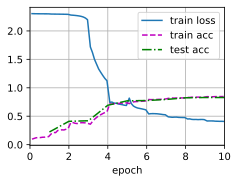

In [143]:
#GoogLeNet
class Inception(nn.Module):
    # `c1`--`c4` are the number of output channels for each path
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # Path 1 is a single 1 x 1 convolutional layer
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        # Path 2 is a 1 x 1 convolutional layer followed by a 3 x 3
        # convolutional layer
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        # Path 3 is a 1 x 1 convolutional layer followed by a 5 x 5
        # convolutional layer
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        # Path 4 is a 3 x 3 maximum pooling layer followed by a 1 x 1
        # convolutional layer
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        # Concatenate the outputs on the channel dimension
        return torch.cat((p1, p2, p3, p4), dim=1)
    
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                   nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveMaxPool2d((1,1)),
                   nn.Flatten())

googlenet = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

#lr, num_epochs, batch_size = 0.1, 10, 128
lr, num_epochs, batch_size = 0.01, 10, 128
train_iter, test_iter = load_data_fashion_mnist(batch_size, resize=96)
train(googlenet, train_iter, test_iter, num_epochs, lr)

loss 0.027, train acc 0.992, test acc 0.926
1288.4 examples/sec on cuda:0


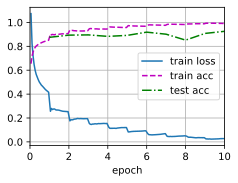

In [142]:
#ResNet
class Residual(nn.Module):  #@save
    """The Residual block of ResNet."""
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))
resnet = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 10))

#lr, num_epochs, batch_size = 0.05, 10, 256
lr, num_epochs, batch_size = 0.01, 10, 64
train_iter, test_iter = load_data_fashion_mnist(batch_size, resize=96)
train(resnet, train_iter, test_iter, num_epochs, lr)